## HB_FakeData
A test file for testing hierarchical bayes and generating data from an RL relationship

HM 2/3

Updated 7/3

In [2]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
numpyro.set_host_device_count(1)
jax.config.update('jax_platform_name', 'cpu')

Instead of going through the expensive process of generating mock DRW data and modelling as a gaussian process, we just use a mock-up of the sort of contours we get in $\Delta t_1$-$\Delta t_2$ space:

In [3]:
def fake_LL(lagtrue, alias_width = 30, true_width = 30, rel_height = 1):
    #This returns the likelihood function in lag-lag space with aliasing peaks and the true peak
    xtrue, ytrue = lagtrue

    def outfunc(x,y):
        out = 0
        for i in [0,1]:
            for j in [0,1]:
                dx = x - (180 + 360*i)
                dy = y - (180 + 360*j)
                r2 = dx**2 + dy**2
                out += jnp.exp(-r2/alias_width**2/2)

        r2 = (x - xtrue)**2 + (y - ytrue)**2
        out+= jnp.exp(-r2/true_width**2/2) * rel_height
        return(out)
    return(outfunc)

Now confirm this is working by plotting the contours for some example:

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


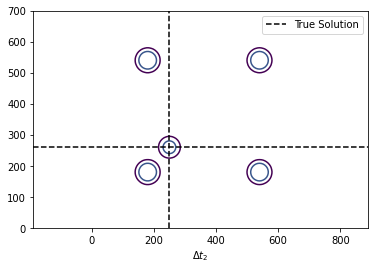

In [4]:
lagtrue = [250, 260]
f = fake_LL(lagtrue = lagtrue, alias_width = 20, rel_height= np.random.rand()*0.5+0.5, true_width= 20)

scanrange = jnp.linspace(0,700, 128)
X,Y = jnp.meshgrid(scanrange, scanrange)
Z = f(X,Y)

plt.contour(X,Y,Z, levels = np.max(Z)*np.exp([-2,-1,0]))
plt.axvline(lagtrue[0], c='k',ls='--', label='True Solution')
plt.axhline(lagtrue[1], c='k',ls='--')
plt.axis('equal')
plt.xlabel("$\Delta t_1$")
plt.xlabel("$\Delta t_2$")
plt.legend(loc="best")
plt.show()

Now we see how well numpyro recovers this with sampling. Because this is a multi-model distribution, we need to use many chains with a random set of initial starting points.

In [7]:
init_lags = [250,260]
true_lags = [250,200]

potential_func = fake_LL(lagtrue = true_lags, alias_width = 10, rel_height= np.random.rand()*0.5+0.5, true_width= 10)

def model():

    x = numpyro.sample('lag_1', numpyro.distributions.Uniform(0,1000))
    y = numpyro.sample('lag_2', numpyro.distributions.Uniform(0,1000))

    numpyro.factor('log_pot', jnp.log(  potential_func(x,y))  )

In [8]:
#Possible Sampler Types

sampler_type = numpyro.infer.NUTS
#sampler_type = numpyro.infer.SA
#sampler_type = numpyro.infer.BarkerMH

#Ways to initialize
init_strat = init_strategy=numpyro.infer.init_to_uniform()
#init_strat  =numpyro.infer.init_to_value(values = {'lag_1': init_lags[0], 'lag_2': init_lags[1]})

sampler_kernel = sampler_type(model = model, init_strategy=init_strat)

print("Beginning sampling...")
sampler = numpyro.infer.MCMC(
    sampler_kernel,
    num_warmup=100,
    num_samples=100,
    num_chains=50,
    progress_bar=False,
    chain_method = 'sequential',
)
sampler.run(jax.random.PRNGKey(10))
print("Done")

Beginning sampling...


/tmp/ipykernel_1179/2426888495.py:14: UserWarning: There are not enough devices to run parallel chains: expected 50 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(50)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = numpyro.infer.MCMC(
sample: 100%|██████████| 200/200 [00:00<00:00, 628.09it/s, 7 steps of size 1.03e+00. acc. prob=0.93]


Done


Now plot this as a chainconsumer plot

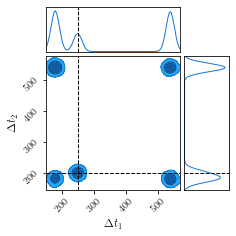

In [9]:
output = sampler.get_samples()
c = ChainConsumer()
c.add_chain([output['lag_1'], output['lag_2']], parameters=['$\Delta t_1$','$\Delta t_2$'])

c.plotter.plot(truth=true_lags)

plt.show()

### Mockup Population Data

Here we generate a population of many sources based on R-L relationships and lag similarity.

<center>
$log|\Delta t_1| \sim N(\alpha_1 \cdot log|L| + \beta _1, \Delta t_1)

\\ log|\Delta t_2| \sim N(\alpha_2 \cdot log|L| + \beta _2, \Delta t_2)$
</center>

And lag similarity, $\Delta t_1 \approx \Delta t_2$, is describe as either:

<center>
$\frac{\Delta t_2}{\Delta t_1} \sim N(\gamma, \Delta_\gamma)$

Or

${\Delta t_2}-{\Delta t_1} \sim N(\gamma -1 , \Delta_\gamma)$

</center>

Here Using
<center>
$\alpha_i = 0.5
\\ \beta_i = 0.5
\\ \Delta_i = 1.0
\\ \gamma = 0.5
\\ \Delta _ \gamma = 0.25$
</center>

In [43]:
#R-L Slopes, Offsets & Spreads
alpha_RL    = [0.5,     0.5]
beta_RL     = [0.5,     0.5]
delta_RL    = [0.5*2,   0.5*2]

#Similarity band left and right
gamma = 1
delta_gamma = 0.25

def makelags(L, lagsim = True, lagsim_prop=False):

    N=len(L)
    #Make initial raft of lags
    lags_1 = np.exp(alpha_RL[0]*np.log(L) + beta_RL[0]+ np.random.normal(size=N)*delta_RL[0])
    lags_2 = np.exp(alpha_RL[1]*np.log(L) + beta_RL[1]+ np.random.normal(size=N)*delta_RL[1])

    #If also using lag similarity:
    if lagsim:
        norm = 1
        good_to_go = np.exp(-(((lags_1 / lags_2) - gamma) / delta_gamma)**2 / 2) / np.sqrt(2*np.pi*delta_gamma) > np.random.rand(N)

        while False in good_to_go:
            #Indices of cells that need to be updated
            inds = np.where(good_to_go==False)[0]

            #Re-roll required cells
            lags_1[inds] = np.exp(alpha_RL[0]*np.log(L[inds]) + beta_RL[0])+ np.random.normal(size=len(inds))*delta_RL[0]
            lags_2[inds] = np.exp(alpha_RL[1]*np.log(L[inds]) + beta_RL[1])+ np.random.normal(size=len(inds))*delta_RL[1]

            #Use proportionality or linear relationship
            if lagsim_prop==True:
                dex = (( (lags_2[inds] / lags_1[inds]) - gamma) / delta_gamma)**2
            else:
                dex = ( (lags_2[inds]*gamma - lags_1[inds] - (gamma-1)) / delta_gamma)**2

            #Check if updated cells are good or need another pass
            good_to_go[inds] = np.exp(-dex/2) / norm > np.random.rand(len(inds))

    return(lags_1,lags_2)

In [46]:
#Actually generate the lags
Nsources = 1000
Lmin = 1
Lmax = 1000
lagsim = True
lagsim_prop = True

L = np.exp(np.random.uniform(low = np.log(Lmin), high = np.log(Lmax), size=Nsources)) # Log Uniform Dist
#L = np.random.uniform(low = Lmin, high = Lmax, size=Nsources) # Uniform

lags = makelags(L, lagsim, lagsim_prop)

print("Lags generated")

Lags generated


Plotting


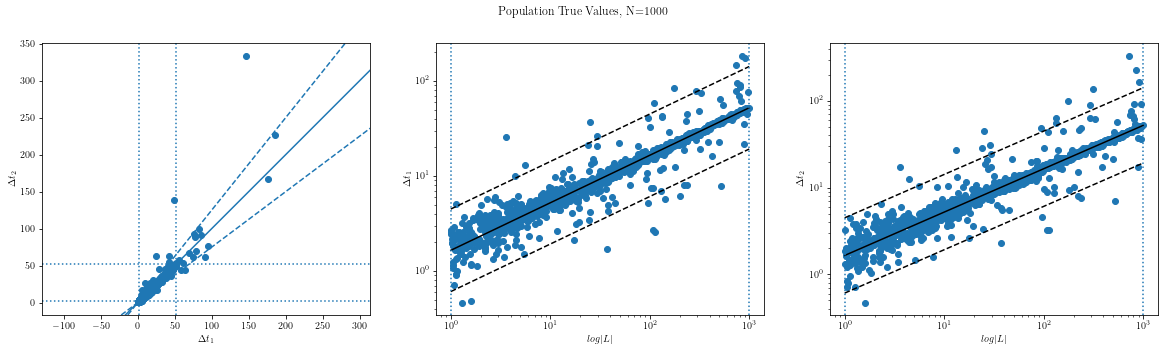

Done


In [47]:
print("Plotting")
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].scatter(lags[0],lags[1])
if lagsim_prop:
    ax[0].axline([0,0], slope = gamma)
    ax[0].axline([0,0], slope = gamma+delta_gamma , ls='--')
    ax[0].axline([0,0], slope = gamma-delta_gamma, ls='--')
else:
    ax[0].axline([0,0], slope = gamma)
    ax[0].axline([0,delta_gamma], slope = gamma , ls='--')
    ax[0].axline([0,-delta_gamma], slope = gamma, ls='--')

ax[0].axis('equal')

ax[0].axvline( np.exp(np.log(Lmin)*alpha_RL[0] + beta_RL[0]), ls=':')
ax[0].axhline( np.exp(np.log(Lmin)*alpha_RL[1] + beta_RL[1]), ls=':')
ax[0].axvline( np.exp(np.log(Lmax)*alpha_RL[0] + beta_RL[0]), ls=':')
ax[0].axhline( np.exp(np.log(Lmax)*alpha_RL[1] + beta_RL[1]), ls=':')

plotspace = np.linspace(Lmin,Lmax, 2)
for i in [1,2]:
    ax[i].scatter(L,lags[i-1])
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

    ax[i].plot( plotspace, np.exp(np.log(plotspace) * alpha_RL[i-1] + beta_RL[i-1]), c='k', ls='-')
    ax[i].plot( plotspace, np.exp(np.log(plotspace) * alpha_RL[i-1] + beta_RL[i-1] - delta_RL[i-1]), c='k', ls='--')
    ax[i].plot( plotspace, np.exp(np.log(plotspace) * alpha_RL[i-1] + beta_RL[i-1] + delta_RL[i-1]), c='k', ls='--')

    ax[i].axvline(Lmin, ls=':')
    ax[i].axvline(Lmax, ls=':')

fig.suptitle("Population True Values, N=%i" %Nsources)
ax[0].set(xlabel='$\Delta t_1$', ylabel='$\Delta t_2$')
ax[1].set(xlabel='$log|L|$', ylabel='$\Delta t_1$')
ax[2].set(xlabel='$log|L|$', ylabel='$\Delta t_2$')

plt.show()
print("Done")
